<a href="https://colab.research.google.com/github/carlomigs/btgym/blob/master/examples/migs_setting_up_environment_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Setting the environment: full power.
_Or: making gym environment happy  with your very own backtrader engine._
****

In [2]:
!git clone https://github.com/Kismuz/btgym.git
%cd btgym
!pip install -e .

Cloning into 'btgym'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 6991 (delta 2), reused 0 (delta 0), pack-reused 6977
Receiving objects: 100% (6991/6991), 126.69 MiB | 23.60 MiB/s, done.
Resolving deltas: 100% (5170/5170), done.
Checking out files: 100% (346/346), done.
/content/btgym
Obtaining file:///content/btgym
     |████████████████████████████████| 419kB 3.5MB/s 
     |████████████████████████████████| 14.6MB 28.3MB/s 
     |████████████████████████████████| 92kB 23.3MB/s 
  Created wheel for logbook: filename=Logbook-1.5.3-cp36-cp36m-linux_x86_64.whl size=66381 sha256=092d19e148d63188e94cbc7848d0d9b1ddc48aa9ca0323cf20c6471e74148025
  Stored in directory: /root/.cache/pip/wheels/d2/70/07/68b99a8e05dcd1ab194a8e0ccb9e4d0ac5dd6d8d139c7149b4
Successfully built logbook
ERROR: plotnine 0.5.1 has requirement matplotlib>=3.0.0, but you'll have matplotlib 2.0.2 which is incompatible

In [1]:
import sys
sys.path.insert(0,'..')

import IPython.display as Display
import PIL.Image as Image
import numpy as np
import random

from gym import spaces

from btgym import BTgymEnv, BTgymBaseStrategy, BTgymDataset

# Handy functions:

def show_rendered_image(rgb_array):
    """
    Convert numpy array to RGB image using PILLOW and
    show it inline using IPykernel.
    """
    Display.display(Image.fromarray(rgb_array))

def render_all_modes(env):
    """
    Retrieve and show environment renderings
    for all supported modes.
    """
    for mode in env.metadata['render.modes']:
        print('[{}] mode:'.format(mode))
        show_rendered_image(env.render(mode))

def take_some_steps(env, some_steps):
    """Just does it. Acting randomly."""
    for step in range(some_steps):
        rnd_action = env.action_space.sample()
        o, r, d, i = env.step(rnd_action)
        if d:
            print('Episode finished,')
            break
    print(step+1, 'actions made.\n')
    
def under_the_hood(env):
    """Shows environment internals."""
    for attr in ['dataset','strategy','engine','renderer','network_address']:
        print ('\nEnv.{}: {}'.format(attr, getattr(env, attr)))

    for params_name, params_dict in env.params.items():
        print('\nParameters [{}]: '.format(params_name))
        for key, value in params_dict.items():
            print('{} : {}'.format(key,value))

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### Define simple custom strategy:
Note using of inner startegy variable **`raw_state`**.

In [0]:
class MyStrategy(BTgymBaseStrategy):
    """
    Example subclass of BTgym inner computation startegy,
    overrides default get_state() and get_reward() methods.
    """
    
    def get_price_gradients_state(self):
        """
        This method follows naming cinvention: get_[state_modality_name]_state
        Returns normalized environment observation state
        by computing time-embedded vector
        of price gradients.
        """
        # Prepare:
        sigmoid = lambda x: 1/(1 + np.exp(-x))
        
        # T is 'gamma-like' signal hyperparameter
        # for our signal to be in about [-5,+5] range before passing it to sigmoid;
        # tweak it by hand to add/remove "peaks supressing":
        T = 1.2e+4
        
        # Use default strategy observation variable to get
        # time-embedded state observation as [m,4] numpy matrix, where
        # 4 - number of signal features  == state_shape[-1],
        # m - time-embedding length  == state_shape[0] == <set by user>.
        X = self.raw_state
        
        # ...while iterating, inner _get_raw_state() method is called just before this one,
        # so variable `self.raw_state` is fresh and ready to use.

        # Compute gradients with respect to time-embedding (last) dimension:
        dX = np.gradient(X)[0]
        
        # Squash values in [0,1]:
        return sigmoid(dX * T)
    
    def get_reward(self):
        """
        Computes reward as log utility of current to initial portfolio value ratio.
        """
        return float(np.log(self.stats.broker.value[0] / self.env.broker.startingcash))
        

In [3]:
import os
#os.getcwd()
!ls btgym/examples/data

DAT_ASCII_EURCHF_M1_2017.csv
DAT_ASCII_EURGBP_M1_2017.csv
DAT_ASCII_EURJPY_M1_2017.csv
DAT_ASCII_EURUSD_M1_2010.csv
DAT_ASCII_EURUSD_M1_2011.csv
DAT_ASCII_EURUSD_M1_2012.csv
DAT_ASCII_EURUSD_M1_2013.csv
DAT_ASCII_EURUSD_M1_2014.csv
DAT_ASCII_EURUSD_M1_2015.csv
DAT_ASCII_EURUSD_M1_2016.csv
DAT_ASCII_EURUSD_M1_201701.csv
DAT_ASCII_EURUSD_M1_201702.csv
DAT_ASCII_EURUSD_M1_201703_1_10.csv
DAT_ASCII_EURUSD_M1_201703.csv
DAT_ASCII_EURUSD_M1_201704.csv
DAT_ASCII_EURUSD_M1_201705.csv
DAT_ASCII_EURUSD_M1_201706.csv
DAT_ASCII_EURUSD_M1_2017.csv
test_bent_sine_1min_period1500_300_delta0002.csv
test_bent_sine_1min_period_300_1500_delta0002.csv
test_sine_1min_period256_delta0002.csv


### Configure environment:
- All strategy parameters shown above that are not meant to be left defaults should be passed to environmnet as kwargs.
- when `verbose=1`, pay attention to log output what classes been used (base or custom).

In [4]:
# Define dataset:
MyDataset = BTgymDataset(
    filename='btgym/examples/data/DAT_ASCII_EURUSD_M1_2016.csv',
     start_weekdays=[0, 1,],
     # leave all other to defaults,
) 

env = BTgymEnv(
    dataset=MyDataset,
    strategy=MyStrategy,
    state_shape={
       'raw': spaces.Box(low=-10, high=10, shape=(4,4)),  # renered under 'human' name
       'price_gradients': spaces.Box(low=0, high=1, shape=(4,4))
    },
    drawdown_call=30,
    skip_frame=5,
    # use default agent actions,
    # use default engine,
    start_cash=100.0,
    # use default commission,
    # use default stake,
    # use default network port,
    render_modes=['episode', 'human', 'price_gradients'],
    render_state_as_image = False,
    render_ylabel = 'Price Gradient',
    # leave other rendering p. to dedaults,
    verbose=1,
)

BTgymDataset class is DEPRECATED, use btgym.datafeed.derivative.BTgymDataset2 instead.
[2019-10-21 16:24:25.527010] INFO: BTgymAPIshell_0: Custom Dataset class used.
[2019-10-21 16:24:25.528090] INFO: BTgymAPIshell_0: Connecting data_server...


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[2019-10-21 16:24:25.721718] INFO: BTgymDataServer_0: PID: 229
[2019-10-21 16:24:26.410340] INFO: SimpleDataSet_0: Loaded 372678 records from <btgym/examples/data/DAT_ASCII_EURUSD_M1_2016.csv>.
[2019-10-21 16:24:26.509425] INFO: SimpleDataSet_0: Data summary:
                open           high            low          close    volume
count  372678.000000  372678.000000  372678.000000  372678.000000  372678.0
mean        1.107109       1.107198       1.107019       1.107108       0.0
std         0.024843       0.024840       0.024847       0.024844       0.0
min         1.035250       1.035470       1.035220       1.035220       0.0
25%         1.092140       1.092230       1.092040       1.092140       0.0
50%         1.113530       1.113610       1.113450       1.113530       0.0
75%         1.124710       1.124780       1.124630       1.124710       0.0
max         1.161440       1.161600       1.160770       1.161450       0.0
[2019-10-21 16:24:26.721743] INFO: BTgymAPIshell_0: ...d

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


[2019-10-21 16:24:27.935193] INFO: BTgymAPIshell_0: Server started, pinging tcp://127.0.0.1:5500 ...
[2019-10-21 16:24:27.939297] INFO: BTgymAPIshell_0: Server seems ready with response: <{'ctrl': 'send control keys: <_reset>, <_getstat>, <_render>, <_stop>.'}>
[2019-10-21 16:24:27.940687] INFO: BTgymAPIshell_0: Environment is ready.


### Take a look...

In [5]:
under_the_hood(env)


Env.dataset: <btgym.datafeed.derivative.BTgymDataset object at 0x7fa2a224e208>

Env.strategy: <class '__main__.MyStrategy'>

Env.engine: <backtrader.cerebro.Cerebro object at 0x7fa2a457b4e0>

Env.renderer: <btgym.rendering.renderer.BTgymRendering object at 0x7fa2a224ec18>

Env.network_address: tcp://127.0.0.1:5500

Parameters [engine]: 
start_cash : 100.0
broker_commission : 0.001
fixed_stake : 10

Parameters [dataset]: 
filename : None
sep : ;
header : 0
index_col : 0
parse_dates : True
names : ['open', 'high', 'low', 'close', 'volume']
timeframe : 1
datetime : 0
open : 1
high : 2
low : 3
close : 4
volume : -1
openinterest : -1
sample_duration : {'days': 0, 'hours': 23, 'minutes': 55}
start_weekdays : [0, 1]
start_00 : False
time_gap : {'days': 0, 'hours': 6}
expanding : False
test_period : None

Parameters [strategy]: 
state_shape : {'raw': Box(4, 4), 'price_gradients': Box(4, 4)}
cash_name : default_cash
asset_names : ['default_asset']
start_cash : None
commission : None
leverage :

***
### Time to run:
- Play with number of steps. Comment out **`env.reset()`** not to restart episode every time you run th cell.
- Refer to 'rendering howto' to get sense of how renerings are updated.

Episode finished,
285 actions made.

[episode] mode:


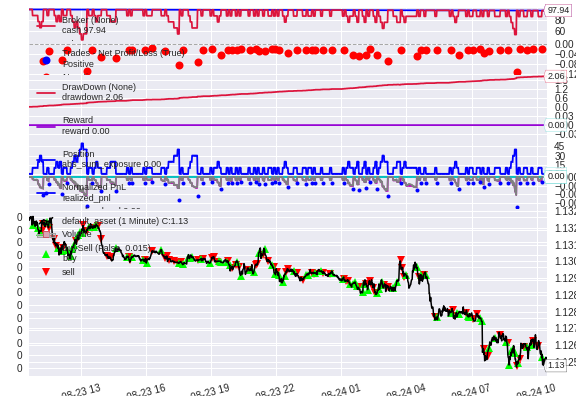

[human] mode:


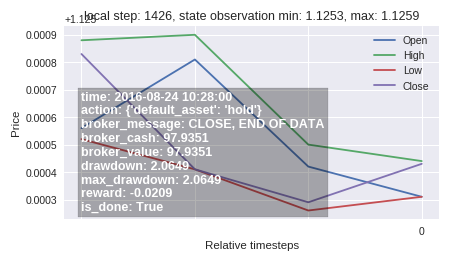

[price_gradients] mode:


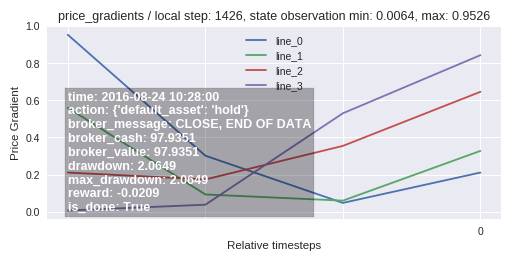

In [8]:
env.reset()
take_some_steps(env, 10000)
render_all_modes(env)

****
### <a name="full"></a>Full Throttle setup:
- Summon Backtrader power;
- Wich-is-what: pay attention to arguments being used or ignored.

In [9]:
# Clean up:
env.close()

# Now we need it:
import backtrader as bt

[2019-10-21 16:27:13.413763] INFO: BTgymAPIshell_0: Exiting. Exit code: None
[2019-10-21 16:27:13.440319] INFO: BTgymAPIshell_0: {'ctrl': 'Exiting.'} Exit code: None
[2019-10-21 16:27:13.442535] INFO: BTgymAPIshell_0: Environment closed.


In [10]:
# Define dataset:
MyDataset = BTgymDataset(
    filename='btgym/examples/data/DAT_ASCII_EURUSD_M1_2016.csv',
    start_weekdays=[0, 1,],
    episode_duration={'days': 2, 'hours': 23, 'minutes': 55},  # episode duration set to about 3 days (2:23:55),
    # leave all other to defaults,
) 


# Configure backtesting engine:
MyCerebro = bt.Cerebro()

# Note (again): all kwargs here will go stright to strategy parameters dict,
# that is our responsibility to consisit observation shape / bounds with what our get_state() computes.
MyCerebro.addstrategy(
    MyStrategy,
    state_shape={
        'raw': spaces.Box(low=-10, high=10, shape=(4,4)),
        'price_gradients': spaces.Box(low=0, high=1, shape=(4,4))
    },
    drawdown_call=99,
    skip_frame=5,
)

# Than everything is very backtrader'esque:
MyCerebro.broker.setcash(100.0)
MyCerebro.broker.setcommission(commission=0.002)
MyCerebro.addsizer(bt.sizers.SizerFix, stake=20)
MyCerebro.addanalyzer(bt.analyzers.DrawDown)

# Finally:
env = BTgymEnv(
    dataset=MyDataset,
    episode_duration={'days': 0, 'hours': 5, 'minutes': 55}, # ignored!
    engine=MyCerebro,
    strategy='NotUsed',  # ignored!
    state_shape=(9, 99), # ignored!
    start_cash=1.0,  # ignored!
    render_modes=['episode', 'human', 'price_gradients'],
    render_state_as_image=True,
    render_ylabel='Price Gradient',   
    render_size_human=(10,4),
    render_size_state=(10,4),
    render_plotstyle='ggplot',
    verbose=0,
)

# Look again...
under_the_hood(env)

BTgymDataset class is DEPRECATED, use btgym.datafeed.derivative.BTgymDataset2 instead.


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)



Env.dataset: <btgym.datafeed.derivative.BTgymDataset object at 0x7fa2a22b7470>

Env.strategy: Custom Cerebro class used.

Env.engine: <backtrader.cerebro.Cerebro object at 0x7fa2a22b7588>

Env.renderer: <btgym.rendering.renderer.BTgymRendering object at 0x7fa2a22b7780>

Env.network_address: tcp://127.0.0.1:5500

Parameters [engine]: 
start_cash : Custom Cerebro class used.
broker_commission : Custom Cerebro class used.
fixed_stake : Custom Cerebro class used.

Parameters [dataset]: 
filename : None
sep : ;
header : 0
index_col : 0
parse_dates : True
names : ['open', 'high', 'low', 'close', 'volume']
timeframe : 1
datetime : 0
open : 1
high : 2
low : 3
close : 4
volume : -1
openinterest : -1
sample_duration : {'days': 2, 'hours': 23, 'minutes': 55}
start_weekdays : [0, 1]
start_00 : False
time_gap : {'days': 0, 'hours': 6}
expanding : False
test_period : None

Parameters [strategy]: 
state_shape : {'raw': Box(4, 4), 'price_gradients': Box(4, 4)}
cash_name : default_cash
asset_names : [

Episode finished,
861 actions made.

[episode] mode:


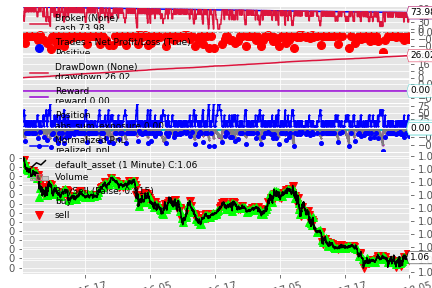

[human] mode:


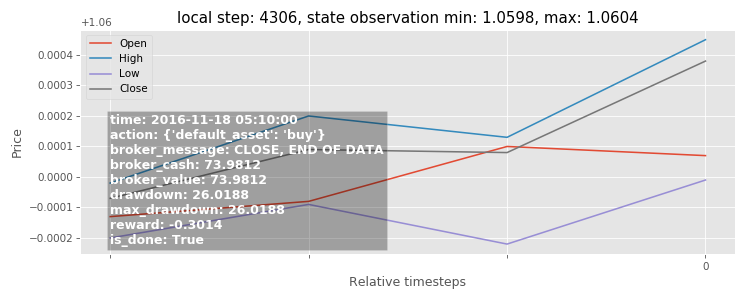

[price_gradients] mode:


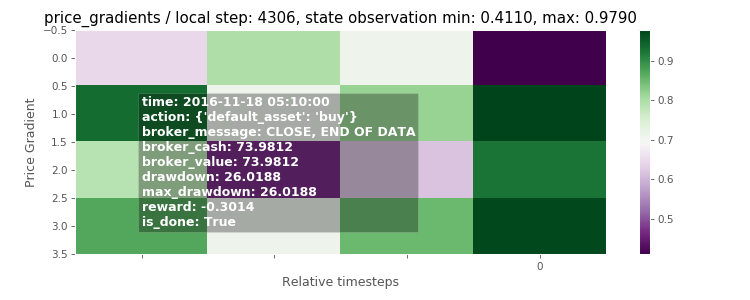

In [12]:
env.reset()
take_some_steps(env, 10000)
render_all_modes(env)

In [0]:
# Clean up:
env.close()